In [1]:
# split train and test set of math symbols
import json
import random
import os

random.seed(777)

symbol_images_dir = 'symbol_images/'
terminals = ['+', '-', 'times', 'div', '(', ')', '!'] + list(map(str, list(range(10))))
sym_train_set = {}
sym_val_set = {}
sym_test_set = {}
for tok in terminals:
    imgs = os.listdir(symbol_images_dir + tok)
    random.shuffle(imgs)
    n_train = int(len(imgs) * 0.75)
    n_val = int(len(imgs) * 0.05)
    sym_train_set[tok] = sorted(imgs[:n_train])
    sym_val_set[tok] = sorted(imgs[n_train:n_train+n_val])
    sym_test_set[tok] = sorted(imgs[n_train+n_val:])
    print(tok, len(imgs))
json.dump(sym_train_set, open('sym_train.json', 'w'))
json.dump(sym_val_set, open('sym_val.json', 'w'))
json.dump(sym_test_set, open('sym_test.json', 'w'))

+ 25112
- 33997
times 3251
div 868
( 14294
) 14355
! 1300
0 6914
1 26520
2 26141
3 10909
4 7396
5 3545
6 3118
7 2909
8 3068
9 3737


In [2]:
from domain import SYM2PROG
import sys
sys.path.insert(0, "..")
sys.path.insert(0, "../semantics/dreamcoder")

from jointer import AST
import os
import random
from PIL import Image
import json
random.seed(777)

class Iterator:
    def __init__(self, l, shuffle=True):
        if shuffle: 
            random.shuffle(l)
        self.list = l
        self.current = -1
        self.shuffle = shuffle
    
    def next(self):
        self.current += 1
        if self.current == len(self.list):
            self.current = 0
            if self.shuffle:
                random.shuffle(self.list)
        return self.list[self.current]

splits = ['train', 'val', 'test']
split2sym = {}
for split in splits:
    sym_set = {k:Iterator(v) for k,v in json.load(open('sym_%s.json'%split)).items()}
    split2sym[split] = sym_set
    

def render_img(img_paths):
    images = [Image.open(symbol_images_dir + x) for x in img_paths]
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)
    max_height = max(heights)

    new_im = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]
    return new_im

def generate_img_paths(tokens, sym_set):
    img_paths = []
    for tok in tokens:
        if tok == '*': tok = 'times'
        if tok == '/': tok = 'div'
        
        img_name = sym_set[tok].next()
        img_paths.append(os.path.join(tok, img_name))   
        
    return img_paths

In [3]:
min_num = 0
max_num = 10
num_list = list(map(str, range(min_num, max_num)))
nonzero_num_list = [x for x in num_list if x != '0']
op_list = ['+', '-', '*', '/']
lps = '('
rps = ')'

print(num_list)
print(op_list, lps, rps)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
['+', '-', '*', '/'] ( )


In [4]:
op2precedence = {'+': 2, '-': 2, '*': 3, '/': 3, '!': 4}
op2arity = {'+': 2, '-': 2, '*': 2, '/': 2, '!': 1}

def parse_infix(expr):
    values = []
    operators = []
    
    head = [-1] * len(expr)
    for (i,sym) in enumerate(expr):
        if sym.isdigit():
            values.append(i)
        elif sym == lps:
            operators.append(i)
        elif sym == rps:
            while expr[operators[-1]] != lps:
                op = operators.pop()
                for _ in range(op2arity[expr[op]]):
                    head[values.pop()] = op
                values.append(op)
            i_lps = operators[-1]
            i_rps = i
            head[i_lps] = op
            head[i_rps] = op
            operators.pop()
        else:
            while len(operators) > 0 and expr[operators[-1]] != lps and \
                op2precedence[expr[operators[-1]]] >= op2precedence[sym]:
                op = operators.pop()
                for _ in range(op2arity[expr[op]]):
                    head[values.pop()] = op
                values.append(op)
            operators.append(i)

    while len(operators) > 0:
        op = operators.pop()
        for _ in range(op2arity[expr[op]]):
            head[values.pop()] = op
        values.append(op)

    root_op = values.pop()
    head[root_op] = -1
    assert len(values) == 0

    return head

def parse_prefix(expr):
    head = [-1] * len(expr)
    arity = [op2arity.get(x, 0) for x in expr]
    for i in range(len(expr)):
        if i == 0: 
            head[i] = -1
            continue
        for j in range(i-1, -1, -1):
            if arity[j] > 0:
                break
        head[i] = j
        arity[j] -= 1
        #print(i, head, arity)

    return head

def flatten(expr):
    if len(expr) == 1:
        return expr
    return [y for x in expr for y in flatten(x)]

def prefix2infix(prefix):
    prefix = list(prefix)
    values = []
    while len(prefix) > 0:
        sym = prefix.pop()
        if sym.isdigit():
            values.append([sym])
        else:
            arity = op2arity[sym]
            precedence = op2precedence[sym]
            
            left = values.pop()
            right = values.pop() if arity == 2 else []
            """
            add parenthesis when:
            (1) left is a compound expression and its operator's precedence < the current operator
            (2) right is a compound expression and its operator's precedence <= the current operator
            here we assume that the operator is left-associative.
            """
            if len(left) > 1 and op2precedence[left[1]] < precedence:
                left = [lps] + left + [rps]
            if len(right) > 1 and op2precedence[right[1]] <= precedence:
                right = [lps] + right + [rps]
                
            new_value = [left, sym, right]
            values.append(new_value)
    
    infix = ''.join(flatten(values.pop()))
    assert len(values) == 0
    return infix

from collections import namedtuple
Parse = namedtuple('Parse', 'sentence head')
def eval_expr(expr, head):
    ast = AST(Parse(expr, head), SYM2PROG)
    return ast.res(), ast.res_all()
    
def eval_expr_by_eval(expr):
    expr_for_eval = []
    for symbol in expr:
        if symbol == '!':
            expr_for_eval[-1] = 'math.factorial(' + expr_for_eval[-1] + ')'
        elif symbol == '/':
            expr_for_eval.append('//')
        else:
            expr_for_eval.append(symbol)
#     try:
#         res = eval("".join(expr_for_eval))
#     except OverflowError:
#         res = None
    res = eval("".join(expr_for_eval))
    return res



expr = '6*(5-2)'
head = parse_infix(expr)
res = eval_expr(expr, head)
print(expr, res, head)

expr = '/+64-31'
head = parse_prefix(expr)
res = eval_expr(expr, head)
print(expr, res, head)

expr = prefix2infix(expr)
head = parse_infix(expr)
res = eval_expr(expr, head)
print(expr, res, head)

6*(5-2) (18, [6, 18, None, 5, 3, 2, None]) [1, -1, 4, 4, 1, 4, 4]
/+64-31 (5, [5, 10, 6, 4, 2, 3, 1]) [-1, 0, 1, 1, 0, 4, 4]
(6+4)/(3-1) (5, [None, 6, 10, 4, None, 5, None, 3, 2, 1, None]) [2, 2, 5, 2, 2, -1, 8, 8, 5, 8, 8]


In [5]:
from itertools import product
from tqdm import tqdm

def enumerate_expression(n_op):
    if n_op == 0:
        return [[x] for x in num_list]
    
    expressions = []
    
    arity = 1
    ops = [op for op in op_list if op2arity[op] == arity]
    inputs = enumerate_expression(n_op-1)
    expressions.extend(product(ops, inputs))
    
    arity = 2
    ops = [op for op in op_list if op2arity[op] == arity]
    inputs = []
    for i in range(n_op):
        input_1 = enumerate_expression(i)
        input_2 = enumerate_expression(n_op - 1 - i)
        inputs.extend(product(input_1, input_2))
    expressions.extend(product(ops, inputs))
    
    expressions = [flatten(x) for x in expressions]
    return expressions

def sample_expression(n_op, n_instances, min_value=0, max_value=float('inf'), non_zero_res=False):
    def sample(n_op):
        if n_op == 0:
            return [random.choice(num_list)]
        op = random.choice(op_list)
        if op2arity[op] == 1:
            return [op] + sample(n_op-1)
        else:
            i = random.randint(0, n_op-1)
            j = n_op - 1 - i
            return [op] + sample(i) + sample(j)
    
    expressions = []
    with tqdm(total=n_instances) as pbar:
        while len(expressions) < n_instances:
            expr = sample(n_op)
            if expr in expressions:
                continue
            head = parse_prefix(expr)
            res, res_all = eval_expr(expr, head)
            if res is not None:
                if non_zero_res and res == 0:
                    continue
                max_res = max(res_all)
                if max_res >= min_value and max_res <= max_value:
                    expressions.append(expr)
                    pbar.update(1)
    return expressions

def generate_expression(n_op, n_instances, min_value=0, max_value=float('inf'), non_zero_res=False):
    if n_op <= 2:
        expressions = []
        for expr in enumerate_expression(n_op):
            head = parse_prefix(expr)
            res, res_all = eval_expr(expr, head)
            if res is not None:
                if non_zero_res and res == 0:
                    continue
                max_res = max(res_all)
                if max_res >= min_value and max_res <= max_value:
                    expressions.append(expr)
    else:
        assert n_instances is not None
        expressions = sample_expression(n_op, n_instances, min_value, max_value, non_zero_res)
    random.shuffle(expressions)
    expressions = expressions[:n_instances]
    
    temp = []
    for expr in expressions:
        expr = prefix2infix(expr)
        head = parse_infix(expr)
        res, res_all = eval_expr(expr, head)
        if res is not None:
            temp.append((expr, head, res, res_all))
    
    return temp

In [6]:
expressions = generate_expression(2, 100000)
print(len(expressions))
print(len([x for x in expressions if x[3] != 0]))
print(len([x for x in expressions if x[3] == 0]))
print(expressions[:3])

29970
29970
0
[('(8+2)/9', [2, 2, 5, 2, 2, -1, 5], 2, [None, 8, 10, 2, None, 2, 9]), ('3+(9-4)', [1, -1, 4, 4, 1, 4, 4], 8, [3, 8, None, 9, 5, 4, None]), ('1/6+5', [1, 3, 1, -1, 3], 6, [1, 1, 6, 6, 5])]


In [7]:
random.seed(12306)
max_op = 20
max_train_op = 10
n_per_length = int(1e3)
n_train = n_per_length
n_test = n_per_length
n_val = int(n_train / 10)
train_exprs = []
val_exprs = []
test_exprs = []

max_value_train = 100
max_value_test = 10000

for n_op in range(max_op + 1):
    if n_op > max_train_op:
        n_train = 0
    expressions = generate_expression(n_op, n_train + n_test, max_value=max_value_train)
    
    if n_train > 0:
        train_exprs.append(expressions[:n_train])
    val_exprs.append(expressions[:min(n_val, n_train)] + expressions[n_train:n_train+n_val])
    test_exprs.append(expressions[:n_train + n_test])
    
    expressions = generate_expression(n_op, n_test, 
                          min_value=max_value_train+1, max_value=max_value_test, non_zero_res=True)
    val_exprs[-1].extend(expressions[:n_val])
    test_exprs[-1].extend(expressions)

    print(n_op, len(train_exprs[-1]), len(val_exprs[-1]), len(test_exprs[-1]))
    
split2exprs = {'train': train_exprs, 'val': val_exprs, 'test': test_exprs}
print([(k, sum([len(x) for x in v])) for k, v in split2exprs.items()])

0 10 10 10
1 390 100 390


  0%|          | 0/1000 [00:00<?, ?it/s]

2 1000 300 2740


100%|██████████| 2000/2000 [00:00<00:00, 14447.32it/s]


3 1000 300 3000


100%|██████████| 2000/2000 [00:00<00:00, 10651.25it/s]


4 1000 300 3000


 51%|█████     | 1019/2000 [00:00<00:00, 10189.31it/s]

5 1000 300 3000


 83%|████████▎ | 1658/2000 [00:00<00:00, 8648.16it/s] 

6 1000 300 3000


 39%|███▉      | 781/2000 [00:00<00:00, 7807.18it/s]

7 1000 300 3000


 34%|███▍      | 690/2000 [00:00<00:00, 6881.40it/s]

8 1000 300 3000


 56%|█████▌    | 1114/2000 [00:00<00:00, 5774.32it/s]

9 1000 300 3000


100%|██████████| 1000/1000 [00:00<00:00, 5019.13it/s]

10 1000 300 3000



 84%|████████▎ | 835/1000 [00:00<00:00, 4242.79it/s]

11 1000 200 2000


 77%|███████▋  | 771/1000 [00:00<00:00, 3768.98it/s]

12 1000 200 2000


 34%|███▍      | 342/1000 [00:00<00:00, 3416.41it/s]

13 1000 200 2000


 36%|███▋      | 365/1000 [00:00<00:00, 3638.60it/s]

14 1000 200 2000


 32%|███▏      | 324/1000 [00:00<00:00, 3235.88it/s]

15 1000 200 2000


 30%|██▉       | 296/1000 [00:00<00:00, 2942.81it/s]

16 1000 200 2000


 19%|█▉        | 192/1000 [00:00<00:00, 1904.74it/s]

17 1000 200 2000


 21%|██        | 207/1000 [00:00<00:00, 2043.76it/s]

18 1000 200 2000


 18%|█▊        | 176/1000 [00:00<00:00, 1751.72it/s]

19 1000 200 2000


100%|██████████| 1000/1000 [00:01<00:00, 636.63it/s]


20 1000 200 2000
[('train', 9400), ('val', 4810), ('test', 47140)]


In [8]:
import math

split2dataset = {}
for split in splits:
    sym_set = split2sym[split]
    exprs = split2exprs[split]
    dataset = []
    idx = 0
    for n_op, expr_list in enumerate(exprs):
        n_instance = math.ceil(n_per_length / len(expr_list))
        if split == 'val':
            n_instance *= 0.1
        for e in expr_list:
            for _ in range(int(math.ceil(n_instance))):
                img_paths = generate_img_paths(e[0], sym_set)
                sample = {'id': '%s_%08d'%(split, idx), 'img_paths':img_paths, 
                      'expr': e[0], 'head': e[1], 'res': e[2], 'res_all': e[3]}
                idx += 1
                dataset.append(sample)
    split2dataset[split] = dataset
    print(split, len(dataset))

train 11170
val 4900
test 48910


[(0, 30.38), (1, 12.04), (2, 6.32), (3, 4.83), (4, 4.09), (5, 3.74), (6, 3.73), (7, 3.4), (8, 3.58), (9, 3.55), (10, 24.33), (101, 0.0)]
[(0, 21.43), (1, 10.9), (2, 4.04), (3, 2.76), (4, 2.71), (5, 2.04), (6, 2.35), (7, 2.31), (8, 2.39), (9, 1.76), (10, 20.39), (101, 26.94)]


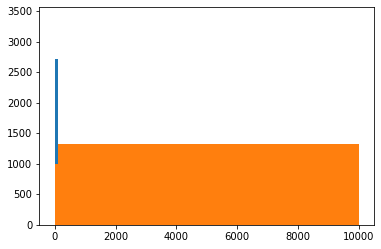

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from collections import Counter

bins = list(range(10)) + [10, max_value_train+1, max_value_test]

dataset = split2dataset['train']
#res_counts = Counter([x['res'] for x in dataset])
#print(sorted(list(res_counts.items())))

n, _, _ = plt.hist([x['res'] for x in dataset], bins=bins)
n = n/n.sum()
print(list(zip(bins, np.round(n*100, 2))))
#plt.show()
#print(random.sample(dataset, k=3))

dataset = split2dataset['val']
res_counts = Counter([x['res'] for x in dataset])
#print(sorted(list(res_counts.items())))
n, _, _ = plt.hist([x['res'] for x in dataset], bins=bins)
n = n/n.sum()
print(list(zip(bins, np.round(n*100, 2))))
#print(random.sample(dataset, k=3))

train 11170 100
[('(', 22268), (')', 22268), ('*', 12874), ('+', 14906), ('-', 14436), ('/', 12954), ('0', 5636), ('1', 7048), ('2', 6973), ('3', 6922), ('4', 6721), ('5', 6720), ('6', 6567), ('7', 6654), ('8', 6601), ('9', 6498)]
[('(', 10720), (')', 10766), ('*', 2438), ('+', 14906), ('-', 14436), ('/', 651), ('0', 5185), ('1', 7048), ('2', 6973), ('3', 6922), ('4', 5547), ('5', 2658), ('6', 2338), ('7', 2181), ('8', 2301), ('9', 2802)]
(8-(0-(5-5)+1))/8+5+0/9 [2, 2, 15, 11, 5, 11, 8, 8, 5, 8, 8, 2, 11, 11, 2, 17, 15, 19, 17, -1, 21, 19, 21] 6


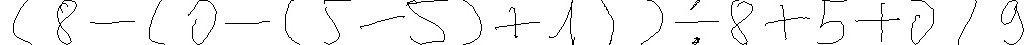

6*((6*9-0)*(0-6/(7/5))) [1, -1, 10, 7, 5, 7, 5, 10, 7, 7, 1, 13, 13, 10, 15, 13, 18, 18, 15, 18, 18, 13, 10] 0


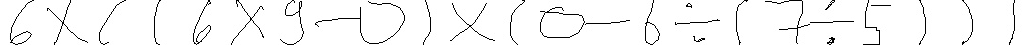

3-5/(6/9*7) [1, -1, 3, 1, 8, 6, 8, 6, 3, 8, 8] 2


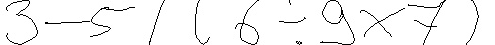

2-(7-8)*3 [1, -1, 4, 4, 7, 4, 4, 1, 7] 2


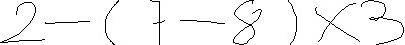

6-(2-(9-0+8-(0/3+2))) [1, -1, 4, 4, 1, 11, 7, 9, 7, 11, 9, 4, 16, 14, 16, 14, 11, 16, 16, 11, 4] 6


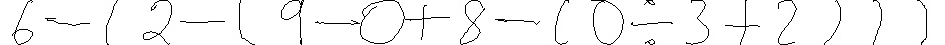

val 4900 9900
[('(', 21081), (')', 21081), ('*', 13491), ('+', 13199), ('-', 10734), ('/', 9876), ('0', 4016), ('1', 5142), ('2', 5321), ('3', 5241), ('4', 5279), ('5', 5383), ('6', 5427), ('7', 5462), ('8', 5453), ('9', 5476)]
[('(', 714), (')', 717), ('*', 162), ('+', 1255), ('-', 1699), ('/', 43), ('0', 345), ('1', 1326), ('2', 1307), ('3', 545), ('4', 369), ('5', 177), ('6', 155), ('7', 145), ('8', 153), ('9', 186)]
3+7-6+(0+(2+3))+5 [1, 3, 1, 5, 3, 15, 8, 8, 5, 11, 11, 8, 11, 11, 8, -1, 15] 14


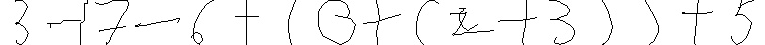

(0+(1*(1+7)+7/5)/4)/((3+8+9)*(3+5)) [2, 2, 19, 11, 5, 11, 8, 8, 5, 8, 8, 16, 13, 11, 13, 11, 2, 16, 2, -1, 28, 25, 23, 25, 23, 28, 25, 25, 19, 31, 31, 28, 31, 31, 28] 1


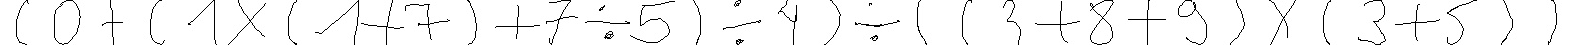

9+(1-(6+5-(0+2)+1)-0*5/2*(3+(1+2)))+(0*9+(9/6+(7-1))) [1, 35, 18, 4, 18, 15, 7, 9, 7, 15, 12, 12, 9, 12, 12, 4, 15, 15, 1, 20, 22, 20, 24, 22, 18, 27, 27, 24, 30, 30, 27, 30, 30, 27, 18, -1, 40, 38, 40, 38, 35, 45, 43, 45, 43, 40, 48, 48, 45, 48, 48, 45, 40] 17


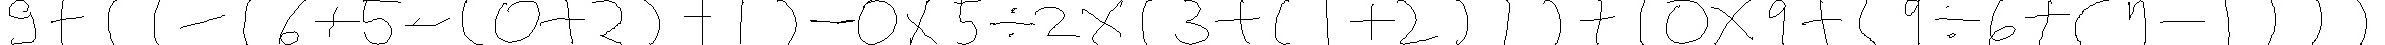

(6+8*((4-0/8/2*3-9)/(6/6/1)/(2+(4-8))))/(3*8/(1/5)) [2, 2, 39, 4, 2, 27, 16, 8, 16, 10, 12, 10, 14, 12, 8, 14, 19, 16, 16, 27, 24, 22, 24, 22, 19, 24, 24, 4, 30, 30, 27, 33, 33, 30, 33, 33, 30, 27, 2, -1, 44, 42, 44, 42, 39, 47, 47, 44, 47, 47, 44] 1


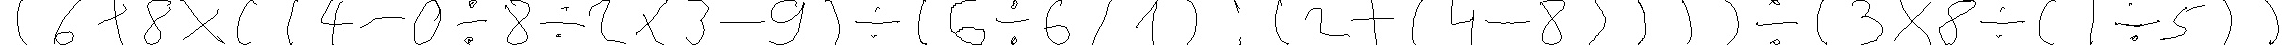

7*(9*3+((8+7)*(5*0/(8+6+(7-7)))+1*4)) [1, -1, 6, 4, 6, 4, 1, 31, 10, 10, 13, 10, 10, 31, 18, 16, 18, 16, 13, 23, 21, 23, 21, 18, 26, 26, 23, 26, 26, 23, 18, 6, 33, 31, 33, 31, 6] 217


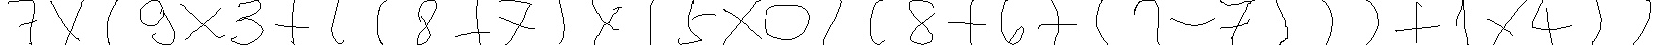

test 48910 9990
[('(', 210691), (')', 210691), ('*', 132837), ('+', 131914), ('-', 108556), ('/', 99343), ('0', 39465), ('1', 51797), ('2', 52546), ('3', 52953), ('4', 53234), ('5', 53430), ('6', 53860), ('7', 54695), ('8', 54671), ('9', 54909)]
[('(', 2860), (')', 2872), ('*', 651), ('+', 5023), ('-', 6801), ('/', 174), ('0', 1384), ('1', 5304), ('2', 5229), ('3', 2183), ('4', 1480), ('5', 710), ('6', 625), ('7', 583), ('8', 614), ('9', 749)]
(8/((6+2)/(5*(1/(1/2)*3)))-(8+7+5))*(1*5*(3/4/(4*9+(3-5)/(2-1)))) [26, 2, 26, 9, 6, 6, 9, 6, 6, 2, 12, 12, 9, 21, 15, 21, 18, 18, 15, 18, 18, 12, 21, 21, 12, 9, 35, 31, 29, 31, 29, 26, 31, 31, 26, -1, 40, 38, 40, 38, 35, 45, 43, 45, 43, 40, 50, 48, 50, 48, 45, 53, 53, 56, 53, 53, 50, 59, 59, 56, 59, 59, 50, 45, 40] 0


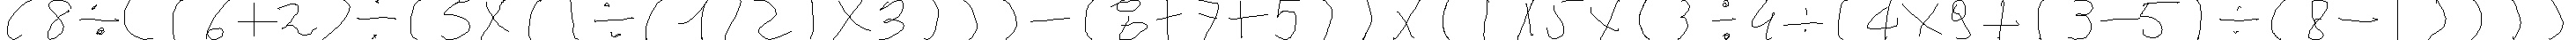

4*(6*9-(3-4))-7*(2*(6-9-8)/(4+3)) [1, 13, 6, 4, 6, 4, 1, 9, 9, 6, 9, 9, 6, -1, 15, 13, 26, 18, 26, 23, 21, 23, 21, 18, 23, 23, 15, 29, 29, 26, 29, 29, 26] 216


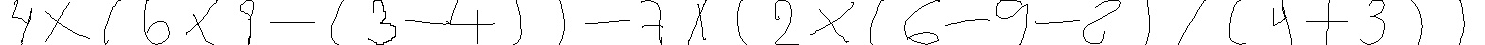

(5+(0/4+1))/1 [2, 2, 11, 7, 5, 7, 5, 2, 7, 7, 2, -1, 11] 6


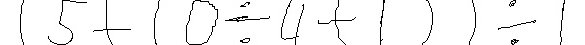

9*1 [1, -1, 1] 9


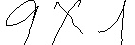

5+6*(3+0)+(2*8*5-1/2) [1, 9, 3, 1, 6, 6, 3, 6, 6, -1, 16, 12, 14, 12, 16, 14, 9, 18, 16, 18, 16] 102


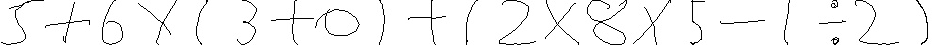

In [19]:
# Visualize data
import numpy as np
for split in splits:
    dataset = split2dataset[split]
    print(split, len(dataset), np.max([x['res'] for x in dataset]))
    all_symbols = [(x, y) for sample in dataset for x, y in zip(sample['img_paths'], sample['expr'])]
    print(sorted(Counter([x[1] for x in all_symbols]).items()))
    print(sorted(Counter([x[1] for x in set(all_symbols)]).items()))
    for _ in range(5):
        sample = random.choice(dataset)
        img_paths = sample['img_paths']
        img = render_img(img_paths)
        print("".join(sample['expr']), sample['head'], sample['res'])
        display(img)

In [11]:
train_exprs = {x['expr'] for x in split2dataset['train']}
max_len_train = max([len(x) for x in train_exprs])
for split in ['val', 'test']:
    dataset = split2dataset[split]
    for sample in dataset:
        expr = sample['expr']
        if expr in train_exprs:
            evaluation = 1
        elif len(expr) <= max_len_train:
            max_value = max([x for x in sample['res_all'] if x is not None])
            if max_value <= max_value_train:
                evaluation = 2
            else:
                evaluation = 3
        else:
            max_value = max([x for x in sample['res_all'] if x is not None])
            if max_value <= max_value_train:
                evaluation = 4
            else:
                evaluation = 5
        sample['eval'] = evaluation

In [12]:
counts = sorted(Counter([x['eval'] for x in split2dataset['test']]).items())
total_count = sum([c for _, c in counts])
counts = [(k, round(v/total_count*100, 2)) for k, v in counts]
print(counts)
print(max_len_train)
print(list({x['expr'] for x in split2dataset['test'] if x['eval'] == 3})[:10])

[(1, 22.84), (2, 23.0), (3, 22.36), (4, 15.84), (5, 15.95)]
37
['8*5*9', '9*((8+2)*(9+6))*(6/8+(0-8))', '2/2/7*(7+7)*4*(4/6+4)', '6*6*5/6', '(9+(5+(0-0))+8)*((9+7)/(8/9))', '5*(9+(6*5-0))-9', '2/9+(6+5*7)*(7-5+7+7)', '5*((4+1/3)*5)+5-(0/2-6+4)/9', '(2+1)/(6*8)+(8+0/3)*(5*(7+1))', '3*8*8']


In [13]:
for split in splits:
    json.dump(split2dataset[split], open('expr_%s.json'%split, 'w'))

(45, 45)


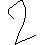

7/1/7-2 = -1.0


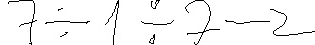

In [14]:
img = Image.open(symbol_images_dir + '2/2_849.jpg')
print(img.size)
display(img)

expr = '7/1/7-2'
img_paths = generate_img_paths(expr, sym_set=sym_set)
img = render_img(img_paths)
print(expr,'=', eval(expr))
display(img)

In [15]:
import json
train_set = json.load(open('expr_train.json'))
val_set = json.load(open('expr_val.json'))

In [16]:
from collections import Counter
def compute_depth(expr):
    depth = 0
    max_depth = 0
    for x in expr:
        if x == lps:
            c = 1
        elif x == rps:
            c = -1
        else:
            c = 0
        depth += c
        if depth > max_depth:
            max_depth = depth
    return max_depth

print(compute_depth('1*2*(1+2*((3+4)+(3-1))'))
ps_depths = [compute_depth(x['expr']) for x in train_set]
print(Counter(ps_depths))

ps_depths = [compute_depth(x['expr']) for x in val_set]
print(Counter(ps_depths))

3
Counter({2: 3320, 1: 3209, 0: 2978, 3: 1376, 4: 257, 5: 26, 6: 4})
Counter({2: 1451, 3: 1255, 1: 963, 4: 631, 0: 421, 5: 146, 6: 26, 7: 7})
